In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

import warnings
warnings.filterwarnings('ignore')

In [0]:
bs = 64

In [0]:
path = untar_data(URLs.PETS)/'images' 

### Data Augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

padding_mode = reflections is best compared to others.

In [0]:
data = get_data(224, bs, 'zeros')

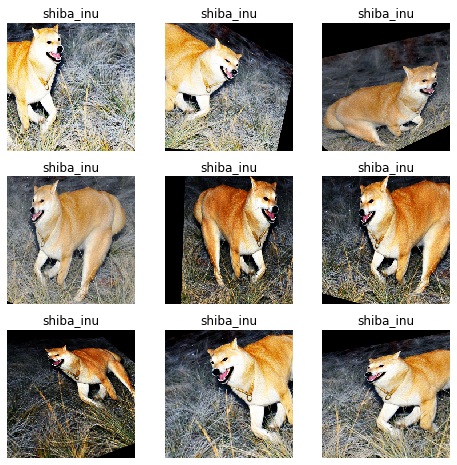

In [8]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
data = get_data(224, bs)

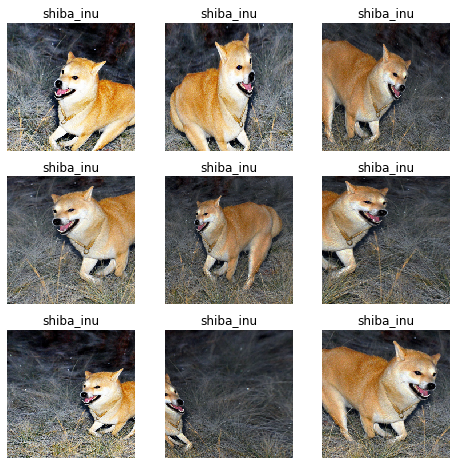

In [10]:
plot_multi(_plot, 3, 3, figsize=(8,8))

### Train a Model

In [11]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 22.3MB/s]


In [12]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.654493,0.366052,0.090663,01:50
1,0.957399,0.291496,0.089986,01:49
2,0.727450,0.246608,0.069012,01:50


In [13]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.590575,0.250908,0.069689,01:55
1,0.558403,0.233065,0.060893,01:54


In [0]:
data = get_data(352,bs)
learn.data = data

In [15]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.512129,0.225567,0.056834,03:28
1,0.468985,0.222431,0.055480,03:28


In [0]:
learn.save('352')


### Convolution kernel

In [0]:
data = get_data(352,16)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category British_Shorthair

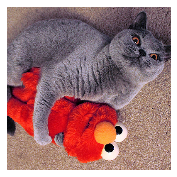

In [19]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [0]:
# 3x3 3 channel kernel 
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [21]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [22]:
k.shape

torch.Size([1, 3, 3, 3])

In [23]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [24]:
# convert it to mini batch torch as fastai layers works only on mini batches.
t[None].shape

torch.Size([1, 3, 352, 352])

In [0]:
edge = F.conv2d(t[None], k)

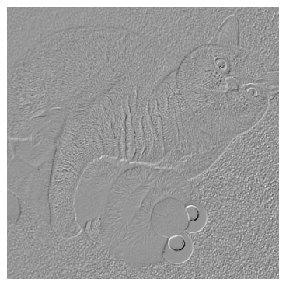

In [28]:
show_image(edge[0], figsize=(5,5));

In [30]:
data.c

37

### Heatmap

In [0]:
m = learn.model.eval()

In [0]:
xb,_ = data.one_item(x)  #one_item used to create mini batch of image
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

In [0]:
# m[0] is the part of model where there is convulation.
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()

In [39]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [40]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

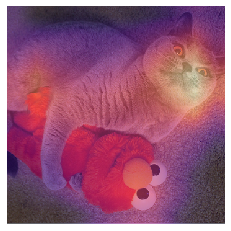

In [42]:
show_heatmap(avg_acts)

### Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [43]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [0]:
mult = (acts*grad_chan[...,None,None]).mean(0)

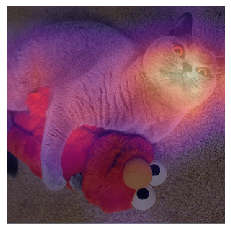

In [45]:
show_heatmap(mult)

In [54]:
import os
os.chdir('/content/')
!wget https://previews.123rf.com/images/cynoclub/cynoclub1508/cynoclub150800004/44052963-puppy-french-bulldog-and-maine-coon-cat-in-front-of-white-background.jpg

--2019-10-27 12:15:05--  https://previews.123rf.com/images/cynoclub/cynoclub1508/cynoclub150800004/44052963-puppy-french-bulldog-and-maine-coon-cat-in-front-of-white-background.jpg
Resolving previews.123rf.com (previews.123rf.com)... 23.214.50.159
Connecting to previews.123rf.com (previews.123rf.com)|23.214.50.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108310 (106K) [image/jpeg]
Saving to: ‘44052963-puppy-french-bulldog-and-maine-coon-cat-in-front-of-white-background.jpg’

44052963-puppy-fren 100%[===================>] 105.77K  --.-KB/s    in 0.03s   

2019-10-27 12:15:06 (3.01 MB/s) - ‘44052963-puppy-french-bulldog-and-maine-coon-cat-in-front-of-white-background.jpg’ saved [108310/108310]



In [0]:
fn = '/content/44052963-puppy-french-bulldog-and-maine-coon-cat-in-front-of-white-background.jpg'

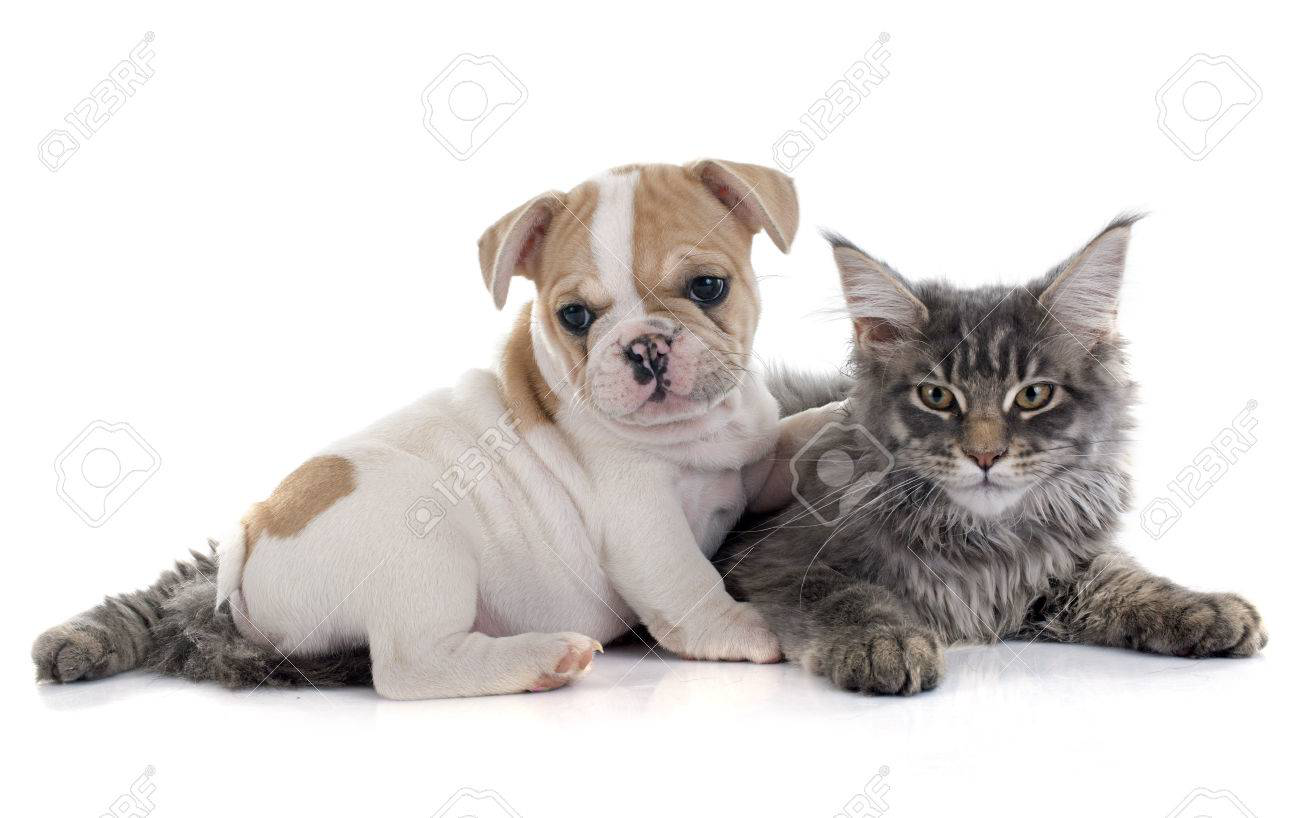

In [56]:
x = open_image(fn); x

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
hook_a,hook_g = hooked_backward()

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

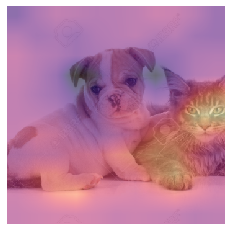

In [60]:
show_heatmap(mult)

In [61]:
data.classes[0]

'Abyssinian'

In [0]:
hook_a,hook_g = hooked_backward(0)

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

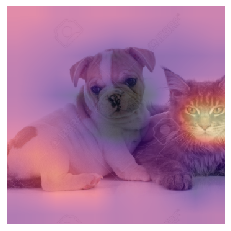

In [64]:
show_heatmap(mult)